## The sampling function for real data

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable

def generate_samples(n):
    r = 1+torch.rand(n,1)*0.1
    theta = 2*3.1415926*torch.rand(n,1)
    x = torch.cos(theta)*r
    y = torch.sin(theta)*r
    return x, y

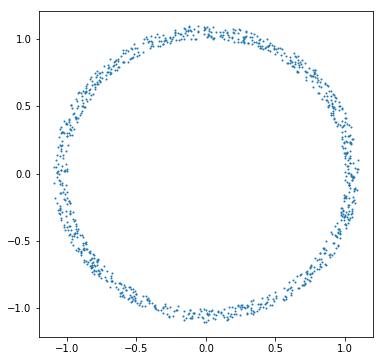

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
n = 1000
x, y = generate_samples(n)
plt.figure(figsize=[6,6])
plt.scatter(x.tolist(), y.tolist(),1)

## Create model

In [3]:
def logsumexp(x):
    x_max, _ = x.max(dim=1,keepdim=True)
    x_max_expand = x_max.expand(x.size())
    res =  x_max + torch.log((x-x_max_expand).exp().sum(dim=1, keepdim=True))
    return res

In [4]:
import math
class GaussianMixture(nn.Module):
    def __init__(self):
        super(GaussianMixture, self).__init__()
        self.main = nn.Sequential(nn.Linear(1,24),
                                  nn.ELU(),
                                  nn.Linear(24,72))
        self.logsoftmax = nn.LogSoftmax()
        self.softmax = nn.Softmax()
    def forward(self, input):
        output = self.main(input)
        mu, log_sigma, pi = output[:,:24], output[:,24:48], output[:,48:]
        return mu, log_sigma, pi
    def logits(self, x, y):
        mu, log_sigma, pi = self.forward(x)
        y_expand = y.expand(mu.size())
        log_pi = self.logsoftmax(pi)
        log_pdf = -0.5*math.log(math.pi*2) - log_sigma - 0.5*((y_expand-mu)/2/log_sigma.exp())**2
        logits = logsumexp(log_pi + log_pdf)
        return logits
    def generate(self, x):
        mu, log_sigma, pi = self.forward(x)
        pi = self.softmax(pi)
        pi_picked = torch.multinomial(pi)
        sigma = log_sigma.exp()
        res = Variable(torch.Tensor(x.size()))
        for i, r in enumerate(pi_picked):
            res[i] = torch.normal(mu[i][r], sigma[i][r])
        return res

## Two helper functions for plots

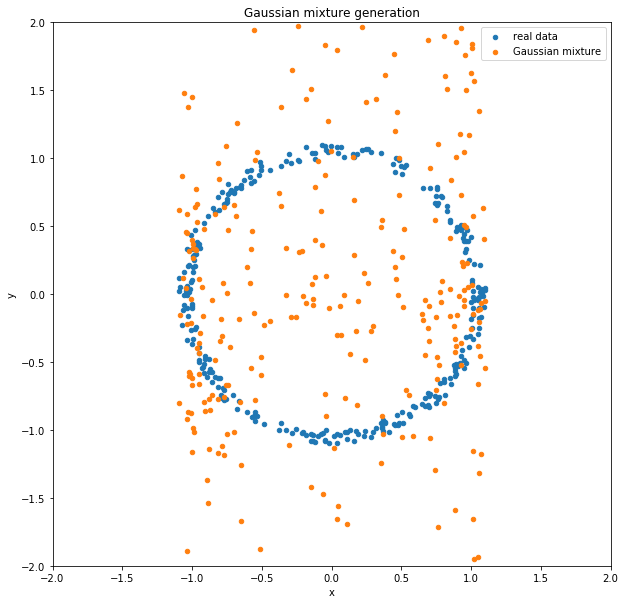

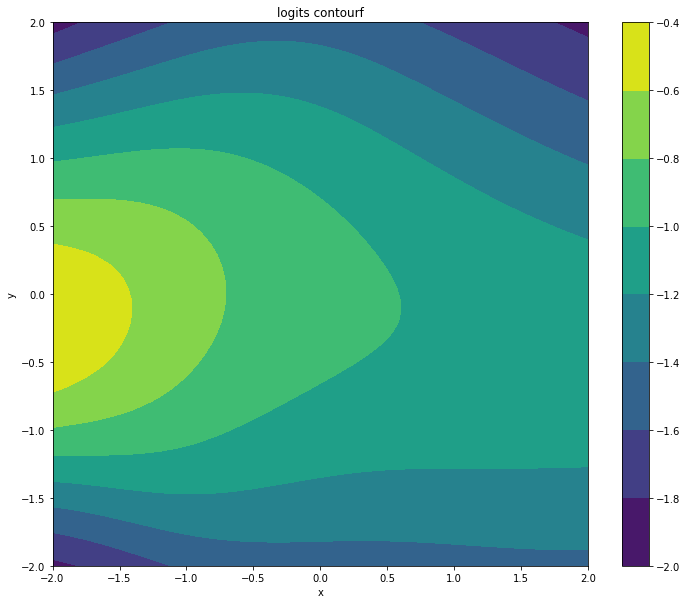

In [5]:
import numpy as np

net = GaussianMixture()
def plot_generated_samples(n=300):
    x,y = generate_samples(n)
    y_gen = net.generate(Variable(x))

    fig = plt.figure(figsize=[10,10])
    plt.scatter(x.tolist(), y.tolist(), 20)
    plt.scatter(x.tolist(), y_gen.data.tolist(),20)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['real data','Gaussian mixture'])
    plt.title('Gaussian mixture generation')
    return fig
plot_generated_samples();

def plot_logits_contour(n=50):
    xs, ys = np.meshgrid(np.linspace(-2,2,n),np.linspace(-2,2,n))
    xs = Variable(torch.Tensor(xs.ravel())).view(-1,1)
    ys = Variable(torch.Tensor(ys.ravel())).view(-1,1)
    logits = net.logits(xs,ys)
    xs, ys, logits = (np.reshape(v.data.numpy(),[n,n]) for v in (xs, ys, logits))
    fig = plt.figure(figsize=[12,10])
    # plt.scatter(xs.data.numpy(), ys.data.numpy(),20, logits.data.numpy())
    plt.contourf(xs, ys, logits)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('logits contourf')
    return fig
plot_logits_contour();


## Network Training 

In [6]:
net = GaussianMixture()

loss_save = []
batch_size = 200
max_epoch = 1000
optimizer = optim.Adam(net.parameters(), lr = 0.01)
m = nn.LogSoftmax()

for epoch in range(max_epoch):
    optimizer.zero_grad()
    x, y = generate_samples(batch_size)
    loss = - net.logits(Variable(x),Variable(y)).mean()
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print("epoch {}, loss {}".format(epoch, loss.data[0]))
    loss_save.append(loss.data[0])

epoch 0, loss 1.0104962587356567
epoch 100, loss -1.1619478464126587
epoch 200, loss -1.374485731124878
epoch 300, loss -1.362694501876831
epoch 400, loss -1.3413493633270264
epoch 500, loss -1.4389238357543945
epoch 600, loss -1.517667293548584
epoch 700, loss -1.5072519779205322
epoch 800, loss -1.5785775184631348
epoch 900, loss -1.578603982925415


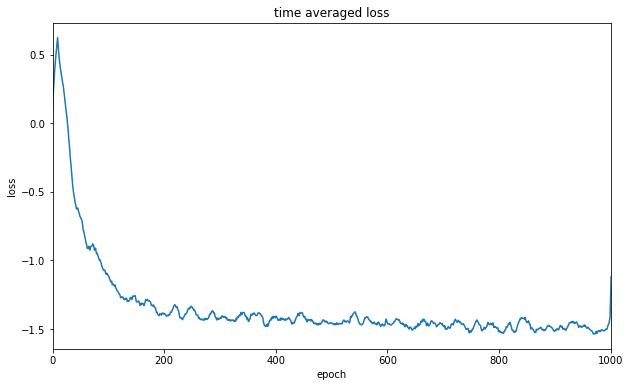

In [7]:
plt.figure(figsize=[10,6])
plt.plot(np.convolve(loss_save, np.ones(10)/10))
plt.xlim([0,max_epoch])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('time averaged loss')

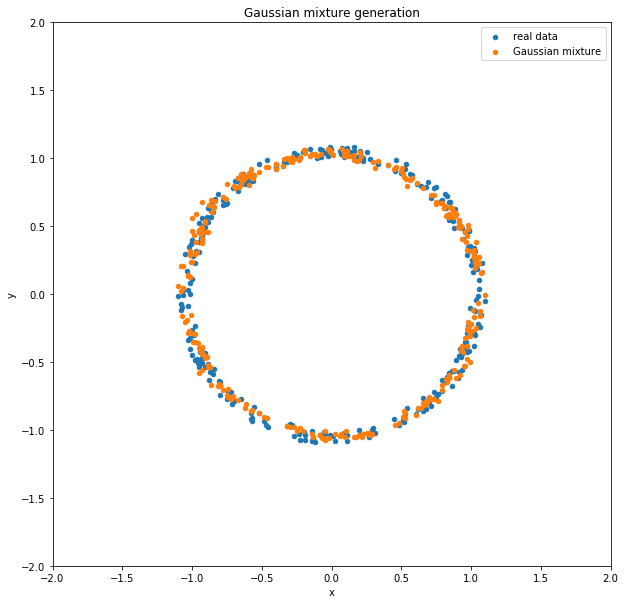

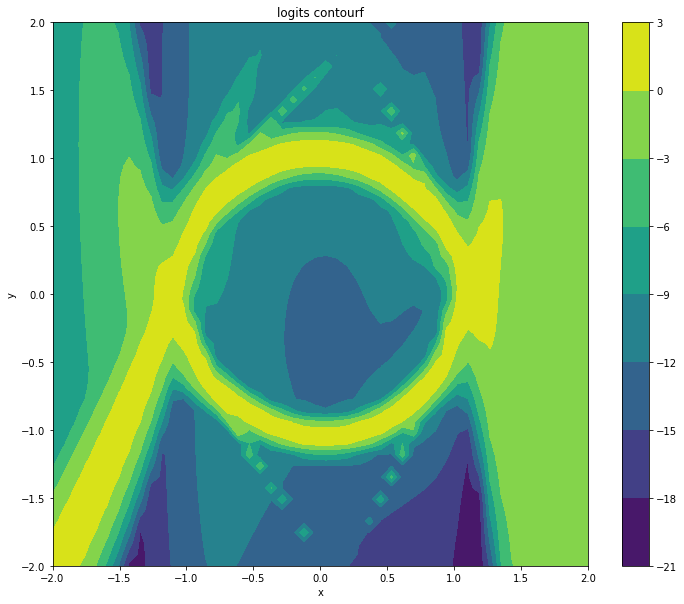

In [8]:
plot_generated_samples();
plot_logits_contour();